<H1> Les word embeddings </H1>  

Les word embeddings (*plongement de mots*) correspondent à des vecteurs qui représentent les mots d’un corpus. La proximité des vecteurs dans l’espace vectoriel correspond à une proximité "sémantique". En fait les vecteurs des mots se retrouvant dans des contextes similaires dans un corpus ont tendance à se rapprocher les uns des autres. L'objectif ici n'est pas de présenter les word embeddings mais plutôt de voir comment les utiliser concrétement.  

**Remarque : il est possible d'afficher où se situent les mots en utilisant par exemple la fonction plot_reduced. Cependant, à cause des évolutions de la librairie, cette dernière doit être corrigée. Cela n'a pas été fait car il ne s'agit pas du point le plus important de ce notebook. Vous pouvez tout à fait mettre à jour la fonction pour prendre en compte les évolutions de la librairie. Merci de le faire et de me tenir au courant afin de modifier le notebook.**

## Installation




Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.

In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...


#!pip install ..

# ne pas oublier de relancer le kernel du notebook

In [16]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
from collections import Counter, defaultdict
import zipfile
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


# librairies gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors # pour charger les fichier gzip bin avec KeyedVectors.load_word2vec_format
from gensim import models
from gensim.models.word2vec import Word2Vec

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize



# librairies Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))



# fonction utilisée pour afficher les embeddings via PCA et t-SNE
def plot_reduced(model,words=None,
                 nb_words=10,
                 svd_solver='full',
                perplexity=100,
                init='pca',
                n_iter=4000,
                random_state=23):
    labels = []
    tokens = []
    if words==None:
        for word in list(model.wv.index_to_key)[:nb_words]:
        #for word in list(model.wv.vocab)[:nb_words]:
            tokens.append(model.wv[word])
            labels.append(word)
    else:
        for word in words[:nb_words]:
            tokens.append(model.wv[word])
            labels.append(word)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 7))
    fig.tight_layout(pad=3.0)

    # Calcul PCA et T-SNE
    pca = PCA(n_components=2,svd_solver=svd_solver)
    pca_result = pca.fit_transform(tokens)

    tsne_model = TSNE(n_components=2, perplexity=perplexity, init=init, n_iter=n_iter, random_state=random_state)
    tsne_result = tsne_model.fit_transform(tokens)

    # plot figures
    ax1.scatter(pca_result[:, 0], pca_result[:, 1])
    ax2.scatter(tsne_result[:, 0], tsne_result[:, 1])
    for i, word in enumerate(labels):
        ax1.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))
        ax2.annotate(word, xy=(tsne_result[i, 0], tsne_result[i, 1]))
    ax1.set_title("PCA")
    ax2.set_title("T-SNE")

    plt.show()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [4]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [6]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024


'/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'

In [7]:
# fonctions utilities (affichage, confusion, etc.)
from MyNLPUtilities import *

## **Première utilisation des word embeddings**  



Dans cette section, nous présentons quelques méthodes associées aux word embeddings et notamment comment apprendre ces fameux mots.  Nous utiliserons pour cela la librairie Gemsin que nous retrouverons d'ailleurs dans le notebook "7 - Extraire les topics".  

Gemsim propose une implémentation des principaux algorithmes de Word2Vec (les modèles skip-gram et CBOW). Word2Vec nécessite en entrée un texte sous la forme de tokens :

In [8]:
Alice="""Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do: once or twice she had peeped into the book her sister was reading,
but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice
`without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel
very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the
trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes
ran close by her.There was nothing so VERY remarkable in that; nor did Alice think it so
VERY much out of the way to hear the Rabbit say to itself,
`Oh dear! Oh dear! I shall be late!' ..(when she thought it
over afterwards, it occurred to her that she ought to have wondered at this,
but at the time it all seemed quite natural).
But when the Rabbit actually TOOK A WATCH OUT OF ITS WAISTCOAT- POCKET, and looked at it,
and then hurried on, Alice started to her feet, for it flashed across her mind that she
had never before see a rabbit with either a waistcoat-pocket, or a watch to take out of it,
and burning with curiosity, she ran across the field after it, and fortunately was just in
time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again.
The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down,
so suddenly that Alice had not a moment to think about stopping herself before she found herself
falling down a very deep well.
Either the well was very deep, or she fell very slowly, for she had plenty of time as she went down
to look about her and to wonder what was going to happen next."""

# application de word_tokenize de NTLK pour transformer en token et convertir en minuscule
sentences = [word_tokenize(s) for s in Alice.lower().split('\n')]
print ('les différents tokens')
print(sentences)

les différents tokens
[['alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', ','], ['and', 'of', 'having', 'nothing', 'to', 'do', ':', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading', ','], ['but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', ',', '`', 'and', 'what', 'is', 'the', 'use', 'of', 'a', 'book', ',', "'", 'thought', 'alice'], ['`', 'without', 'pictures', 'or', 'conversation', '?', "'"], ['so', 'she', 'was', 'considering', 'in', 'her', 'own', 'mind', '(', 'as', 'well', 'as', 'she', 'could', ',', 'for', 'the', 'hot', 'day', 'made', 'her', 'feel'], ['very', 'sleepy', 'and', 'stupid', ')', ',', 'whether', 'the', 'pleasure', 'of', 'making', 'a', 'daisy-chain', 'would', 'be', 'worth', 'the'], ['trouble', 'of', 'getting', 'up', 'and', 'picking', 'the', 'daisies', ',', 'when', 'suddenly', 'a', 'white', 'rabbit', 'with', 'pink', 'eyes'], ['ran

L'apprentissage des words embeddings se fait simplement en appliquant Word2Vec sur les phrases transformées. Il existe de nombreux paramètres pour Word2Vec :  
1. *sg*, 0 ou 1, qui précise si le modèle est de type Skig-gram ou CBOW, sg=0 pour CBOW (valeur par défaut) et sg=1 pour Skip-gram.
1. *min_count*, entier, qui permet d'ignorer tous les tokens qui ont une fréquence absolue inférieure à ce seuil (e.g. 1, 100).
1. *window*, entier, qui précise la distance maximale entre le mot actuel et le mot prédit dans une phrase (e.g. 2, 10).
1. *size*, entier, qui correspond au nombre de dimensions des vecteurs de caractéristiques (e.g. 50, 200)spécifie le nombre minimal d'occurrences d'un token pour être conservé.
1. *alpha*, réel, qui correspond au taux d'apprentissage initial (e.g. 0,01).
1. *workers*, entier, qui spécifie le nombre de threads pour l'entraînement (utilisation de multi coeurs) (e.g. 8).

De plus amples informations sur l'ensemble des paramètres est disponbible ici : https://radimrehurek.com/gensim/models/word2vec.html

In [9]:
# Apprentissage du modèle
model = Word2Vec(sentences, min_count=1)

# Résumé du modèle appris
print(model)

Word2Vec<vocab=174, vector_size=100, alpha=0.025>


Pour connaître le vocabulaire qui a été appris :

In [11]:
# récupération du vocabulaire qui est actuellement dans l'objet model.vw
words = list(model.wv.index_to_key)
#words = list(model.wv.vocab)
print(words)

[',', 'the', 'to', 'she', 'it', 'a', 'and', 'of', 'was', 'her', 'very', 'alice', 'in', 'down', 'or', '.', 'had', 'so', 'for', 'out', 'that', 'rabbit', 'well', '!', 'at', 'time', "'", 'with', 'but', 'suddenly', 'when', 'as', '`', 'on', 'went', 'herself', 'thought', 'think', 'watch', 'ran', 'way', 'moment', 'about', '(', 'nothing', 'sister', ')', 'considering', 'after', 'what', 'be', 'deep', 'before', 'oh', 'book', 'get', 'rabbit-hole', 'either', 'then', 'see', 'never', 'across', 'once', 'dear', 'pictures', 'by', 'mind', 'stupid', 'sleepy', 'twice', 'whether', 'sitting', 'pleasure', 'making', 'would', 'tired', 'worth', 'beginning', 'trouble', 'daisy-chain', 'own', 'feel', 'use', 'peeped', 'into', 'reading', 'no', 'conversations', ':', 'up', 'is', 'do', 'made', 'without', 'conversation', '?', 'having', 'bank', 'could', 'hot', 'day', 'getting', 'next', 'picking', 'fortunately', 'another', 'hedge', 'under', 'large', 'pop', 'just', 'field', 'world', 'curiosity', 'burning', 'take', 'waistcoat

Pour connaître le vecteur associé à un mot :

In [12]:
print(model.wv['alice'])

[ 9.60393529e-03  8.22514761e-03  1.30373519e-03  5.09076193e-03
  1.36596314e-03 -6.85664499e-03 -1.23143778e-03  6.81231543e-03
 -4.80374321e-03 -4.15228028e-03  5.02182636e-03  2.50680512e-03
 -1.83458393e-03 -2.86172354e-03  6.12769974e-03 -5.72174881e-03
 -3.14509100e-03 -6.80236705e-03 -4.43135435e-03 -8.80760048e-03
 -4.34738537e-03 -8.49923305e-03  1.40082370e-03 -8.71896744e-03
 -1.00972615e-02 -8.17788951e-03 -6.76301401e-03  6.58402452e-03
  3.72751057e-03  3.57526063e-04 -2.80362461e-03 -7.37715559e-03
  6.11765776e-04  4.72149550e-04  1.37327210e-04  1.09504838e-03
  9.17320838e-04 -1.15234790e-04 -8.03313963e-03 -5.99053921e-03
 -8.22132267e-03 -1.49063114e-03  1.76889007e-03  7.44214887e-03
 -1.73409178e-03 -2.40426720e-03  9.44790523e-03  1.72724031e-05
 -2.32307613e-03  8.66820663e-03  2.84646056e-03 -5.37414523e-03
  6.76870439e-03  4.43360489e-03 -7.08301971e-03 -2.47647433e-04
  9.54039919e-04  5.92301833e-03 -1.74178858e-03 -2.65716435e-03
  1.74068823e-03  9.45818

L'apprentissage d'un modèle peut prendre beaucoup de temps. Il est donc préférable de le sauvegarder :

In [13]:
# sauvegarde du modèle
model.save('model_alice.bin')

La lecture du modèle se fait alors simplement :

In [14]:
new_model = Word2Vec.load('model_alice.bin')
print(new_model)

Word2Vec<vocab=174, vector_size=100, alpha=0.025>


Pour connaître les mots les plus proches, il suffit de faire appel à la méthode *most_similar* :

In [19]:
les_plus_proches_d_alice=model.wv.most_similar('alice',topn=20)
print ("les 20 mots les plus proches d'alice sont :")
print (les_plus_proches_d_alice)

# pour les afficher
#words_to_plot = []
#words_to_plot.append("alice")
#for i in range(len(les_plus_proches_d_alice)):
#    words_to_plot.append(les_plus_proches_d_alice[i][0])
#plot_reduced(model,words_to_plot,nb_words=len(words_to_plot))

les 20 mots les plus proches d'alice sont :
[('sleepy', 0.3199680745601654), ('deep', 0.3137681186199188), (':', 0.1923096776008606), ('pleasure', 0.19040663540363312), ('when', 0.18820975720882416), ('to', 0.1822614073753357), ('ought', 0.18210141360759735), ('a', 0.17807245254516602), ('feel', 0.17702773213386536), ('up', 0.17541265487670898), ('twice', 0.17465075850486755), ('say', 0.16666018962860107), ('`', 0.1627386063337326), ('then', 0.1612040102481842), ('close', 0.16038218140602112), ('waistcoat-', 0.157505601644516), ('dear', 0.1514345407485962), ('late', 0.14594659209251404), ('occurred', 0.14321528375148773), ('for', 0.14258666336536407)]


Il est également possible de calculer la similarité entre deux mots :

In [20]:
print ("Similarité entre alice et rabbit : ")
model.wv.similarity('alice','rabbit')

Similarité entre alice et rabbit : 


0.08838511

<font color=red>Exercice :</font> en vous inspirant des codes précédents, apprenez le modèle à partir de tous les textes exprimés sur notre jeu de donées d'opinion. Nommer le modèle appris : *model_reviews* pour pouvoir l'utiliser par la suite et penser à le sauvegarder (*'model_reviews.bin'*). Faire un plot des 80 premiers mots. Vous rechercherez également les 80 termes les plus proches d'"amazon".



Le fichier d'opininion a été présenté en M1. Pour rappel il s'agit d'opinions exprimées par des utilisateurs. Vous pouvez le récupérer ici.

In [22]:
!wget https://www.lirmm.fr/~poncelet/Ressources/ReviewsLabelled.csv

--2023-09-07 22:22:52--  https://www.lirmm.fr/~poncelet/Ressources/ReviewsLabelled.csv
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222119 (217K) [text/csv]
Saving to: ‘ReviewsLabelled.csv’

ReviewsLabelled.csv 100%[===================>] 216.91K   245KB/s    in 0.9s    

2023-09-07 22:22:54 (245 KB/s) - ‘ReviewsLabelled.csv’ saved [222119/222119]



In [23]:
df_donnees=pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')
print (df_donnees.head())

# récupération des phrases dans Sentences pour faciliter le traitement
Sentences=df_donnees['sentence'].copy()

                                            sentence  sentiment  source
0  So there is no way for me to plug it in here i...          0  amazon
1                        Good case, Excellent value.          1  amazon
2                             Great for the jawbone.          1  amazon
3  Tied to charger for conversations lasting more...          0  amazon
4                                  The mic is great.          1  amazon


<font color=blue>Solution :</font>


In [25]:
# il faut au préalable transformer le jeu de données en tokens.
# Il est possible d'utiliser le moyen précédent ou bien celui décrit ci-dessous qui utilise Spacy.
# Ensuite, il suffit d'apprendre le modèle et de sélectionner les topn=80 most_similar.


from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

# Extraction des tokens en utilisant Spacy
nlp = English()

Sentences=df_donnees['sentence'].copy()
TokensSentences=[]
for line in Sentences:
    tokens=nlp(line)
    tok_text=[token.text.lower() for token in tokens]
    TokensSentences.append(tok_text)

# Apprentissage du modèle
model_reviews = Word2Vec(TokensSentences, min_count=1)

# Résumé du modèle appris
print(model_reviews)
# sauvegarde du modèle
model_reviews.save('model_reviews.bin')



# les plus proches d''amazon'
les_plus_proches_d_amazon=model_reviews.wv.most_similar('amazon',topn=80)
print ("les 20 mots les plus proches d'amazon sont :")
print (les_plus_proches_d_amazon)



Word2Vec<vocab=5261, vector_size=100, alpha=0.025>
les 20 mots les plus proches d'amazon sont :
[('know', 0.9907065033912659), ('right', 0.9906553030014038), ('scenes', 0.9904983043670654), ('well', 0.9904832243919373), ('down', 0.9903900027275085), ('over', 0.9903820157051086), ('beautiful', 0.9903637170791626), ('battery', 0.9903544187545776), ('never', 0.9903448224067688), ('being', 0.9903095960617065), ('go', 0.9902552962303162), ('by', 0.9902533292770386), ('we', 0.9902468919754028), ('found', 0.9902238845825195), ('movies', 0.9902141094207764), ('my', 0.9901977777481079), ('like', 0.9901965856552124), ('even', 0.9901891946792603), ('will', 0.9901833534240723), ('about', 0.9901797771453857), ('be', 0.9901759028434753), ('could', 0.9901720285415649), ('our', 0.9901668429374695), ('want', 0.9901620149612427), ("n't", 0.99015873670578), ('/', 0.9901570677757263), ('work', 0.9901479482650757), ('do', 0.9901462197303772), ('every', 0.9901440143585205), ('into', 0.9901279211044312), ('o

## **Des exemples de word embeddings**




Il existe de très nombreuses listes de word embeddings disponibles à l'heure actuelle.

**Attention :** charger des embeddings est très coûteux en terme d'espace disque et de mémoire (RAM),   aussi  Colab risque dans sa version gratuite de ne pas avoir assez de mémoire. Aussi, dans cette section, nous ne présentons l'utilisation que d'un sous ensemble de Glove de Stanford. Des indications sont données pour utiliser le jeu de données de Google qui contient 3 millions de vecteurs de mots avec une dimension de 300 (les cellules sont actuellement au format texte, il suffit de convertir les cellules et de les exécuter via CTRL-M Y). Attention ce jeu de données est très volumineux sur votre disque et occupe beaucoup de mémoire.




Nous utilons dans cette section un sous ensemble du  modèle Glove proposé par Stanford qui a été appris à partir de Wikipedia (2014) et de la base Gigaword 5 (ensemble de News). Dans le sous ensemble les vecteurs sont de dimensions 50 et 100. Il est possible de récupérer les données originales à l'adresse suivante : http://nlp.stanford.edu/data/glove.6B.zip ou des vecteurs de dimensions 200 et 300 sont également disponibles.

In [26]:
!wget https://www.lirmm.fr/~poncelet/Ressources/smallglove.6B.zip

--2023-09-07 22:24:00--  https://www.lirmm.fr/~poncelet/Ressources/smallglove.6B.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203649037 (194M) [application/zip]
Saving to: ‘smallglove.6B.zip’

smallglove.6B.zip   100%[===================>] 194.21M  12.2MB/s    in 17s     

2023-09-07 22:24:21 (11.3 MB/s) - ‘smallglove.6B.zip’ saved [203649037/203649037]



In [27]:
# dezippe le fichier glove -> 2 fichiers textes en sortie
import zipfile # pour charger des fichiers zip
getzip = zipfile.ZipFile('smallglove.6B.zip')
getzip.extractall()

**Attention :** pour ce fichier, gensim a besoin de plus d'informations, il est donc indispensable d'ajouter  deux nombres à la première ligne. Le premier indique le nombre de mots de vocabulaire et le second indique le nombre de dimensions. Par exemple, pour effectuer les transformations sur le fichier glove.6B.100d.txt, nous pouvons utiliser le code ci-dessous:

In [28]:
!python -m gensim.scripts.glove2word2vec --input  glove.6B.100d.txt --output glove.6B.100d.w2vformat.txt
!python -m gensim.scripts.glove2word2vec --input  glove.6B.50d.txt --output glove.6B.50d.w2vformat.txt

2023-09-07 22:24:33,416 - glove2word2vec - INFO - running /usr/local/lib/python3.10/dist-packages/gensim/scripts/glove2word2vec.py --input glove.6B.100d.txt --output glove.6B.100d.w2vformat.txt
/usr/local/lib/python3.10/dist-packages/gensim/scripts/glove2word2vec.py:125: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  num_lines, num_dims = glove2word2vec(args.input, args.output)
2023-09-07 22:24:33,418 - keyedvectors - INFO - loading projection weights from glove.6B.100d.txt
2023-09-07 22:25:15,410 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from glove.6B.100d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-09-07T22:25:15.391050', 'gensim': '4.3.2', 'python': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]', 'platform': 'Linux-5.15.109+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2023-09-07 22:25:

In [29]:
from gensim import models
model_stanford = models.KeyedVectors.load_word2vec_format("glove.6B.100d.w2vformat.txt", binary=False)

Affichage du nombre de mots et des dix premiers mots :

In [34]:
#words_stanford = list(model_stanford.vocab)
words_stanford = list(model_stanford.key_to_index)
print("nombre de mots : ",len(words_stanford))
print ('les 10 premiers mots : ')
print (words_stanford[0:10])

nombre de mots :  400000
les 10 premiers mots : 
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]


L'exemple bien connu des embeddings :

In [35]:
# calcul de (king - man) + woman = ?
result = model_stanford.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)


[('queen', 0.7698540687561035)]


Les mots proches de queen :

In [39]:
# les 50 mots les plus similaires à queen
queen_words=model_stanford.most_similar('queen',topn=50)
print (queen_words)


[('princess', 0.7947245240211487), ('king', 0.7507690191268921), ('elizabeth', 0.7355712056159973), ('royal', 0.7065026164054871), ('lady', 0.7044796943664551), ('victoria', 0.6853758096694946), ('monarch', 0.6683257818222046), ('crown', 0.6680562496185303), ('prince', 0.6640506386756897), ('consort', 0.6570538282394409), ('majesty', 0.6483591198921204), ('daughter', 0.6395184397697449), ('duchess', 0.6349949836730957), ('coronation', 0.6347758173942566), ('throne', 0.6307163834571838), ('mary', 0.6274112462997437), ('sister', 0.623155951499939), ('mother', 0.6169340014457703), ('wife', 0.616171658039093), ('margaret', 0.6038228869438171), ('empress', 0.6027787923812866), ('diana', 0.5942181944847107), ('anne', 0.593601405620575), ('her', 0.5841605067253113), ('windsor', 0.5831418037414551), ('crowned', 0.5812687873840332), ('palace', 0.5768924355506897), ('buckingham', 0.5743598937988281), ('widow', 0.573192298412323), ('dowager', 0.5710328817367554), ('vi', 0.5680164098739624), ('hon

In [40]:
# Les mots les plus proches de breakfast et lunch
result = model_stanford.most_similar(positive=['breakfast', 'lunch'], topn=10)
print(result)

[('dinner', 0.8612232804298401), ('meal', 0.763872504234314), ('meals', 0.7489128112792969), ('dinners', 0.7124784588813782), ('buffet', 0.7123857140541077), ('brunch', 0.710158109664917), ('dining', 0.7007660865783691), ('lunches', 0.6790024042129517), ('luncheon', 0.6661798357963562), ('lunchtime', 0.6571982502937317)]


#### **Cas des embeddings de Google**



Pour utiliser les embeddings de Google, il faut transformer les cellules suivantes en tapant sur chaque cellule de code CTRL-M Y.
**Attention :** le jeu de données est très volumineux et pose des problèmes de mémoire sous Colab.




!wget -P . "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz


from gensim import models

model_from_google = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Affichage du nombre de mots et des dix premiers mots :

words_google = list(model_from_google.wv.vocab)
print("nombre de mots : ",len(words_google))
print ('les 10 premiers mots : ')
print (words_google[0:10])

L'exemple bien connu des embeddings : calcul de (king - man) + woman = ?


result = model_from_google.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

Etant donné que les embeddings ont été appris sur un corpus de données volumineux, de nombreuses corrélations apparaissent comme nous pouvons le constater :  


queen_words=model_from_google.wv.most_similar('queen',topn=50)

words_to_plot = []
words_to_plot.append("queen")
for i in range(len(queen_words)):
    words_to_plot.append(queen_words[i][0])
plot_reduced(model_from_google,words_to_plot,nb_words=len(words_to_plot))


result = model_from_google.most_similar(positive=['breakfast', 'lunch'], topn=10)
print(result)

### **Utiliser les word embeddings dans les classifiers**

  

Dans cette section, nous analysons comment utiliser les word embeddings dans les classifieurs "traditionnels", i.e. que nous avons l'habitude d'utilser jusqu'à présent. Le principe général est dans un premier temps de rechercher et de ne retenir que les mots, i.e. des embeddings, qui sont présents dans les documents. Par la suite, étant donné que les embeddings sont des vecteurs, il est nécessaire de les transformer afin de ne conserver qu'une valeur représentative pour le mot. Pour cela, il existe différentes stratégies : utilisation de la moyenne, du min ou du max.   

Nous proposons, ci-dessous, une classe de transormation qui, à partir de documents transformés en tokens, va extraire les word embeddings correspondant aux tokens des documents et prendre en fonction du paramètre passé la moyenne, le minimum ou le maximum des valeurs du vecteur pour l'affecter au mot du corpus.

In [45]:
from sklearn.base import TransformerMixin
class MyEmbeddingVectorizer(TransformerMixin):
  def __init__(self, model, aggregatefunction='mean'):
    self.word_vectors = model
    self.aggregation= aggregatefunction

  def fit(self, data, y=0):
    pass

  def transform(self, data):
    # determiner la dimension des vecteurs
    #size_vectors = self.word_vectors.wv.vectors
    size_vectors = self.word_vectors.vectors
    # le nombre de dimensions est dans shape [1]
    self.D = size_vectors.shape[1]

    # creation d'une matrice avec des zéros
    # cela permet de remplir même si le mot n'est pas trouvé
    X = np.zeros((len(data), self.D))

    n = 0
    for sentence in data:
      # sentence est un document transformé en tokens
      vecs = []
      m = 0
      for word in sentence:
        try:
          # lever l'exception si un mot n'est pas trouvé dans les embeddings
          #vec = self.word_vectors.wv[word]
          vec = self.word_vectors[word]
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        # transformation du vecteur en fonction de la fonction d'agrégation
        if self.aggregation=='mean':
          X[n]= vecs.mean(axis=0)
        if self.aggregation=='min':
          X[n]= vecs.min(axis=0)
        if self.aggregation=='max':
          X[n]= vecs.max(axis=0)
      n += 1
    return X

  def fit_transform(self, data,y=0):
    self.fit(data)
    return self.transform(data)

Accuracy : 0.782
Classification Report
              precision    recall  f1-score   support

           0    0.76737   0.82468   0.79499       308
           1    0.79926   0.73630   0.76649       292

    accuracy                        0.78167       600
   macro avg    0.78331   0.78049   0.78074       600
weighted avg    0.78289   0.78167   0.78112       600



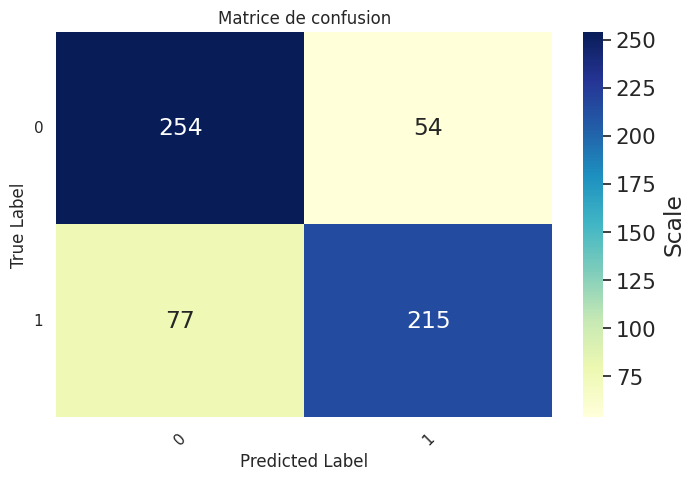

In [46]:
# recuperation des X et y
# les phrases ont été transformées précédemment en tokens (TokenSentences)

X=TokensSentences.copy()
y=df_donnees.sentiment

# nous utilisons une approche simple juste pour tester :
# Création du jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# transformation des tokens des phrases par le vecteur de l'embeddings auquel une
# fonction d'agrégation est appliquée ('mean', 'max', 'min')
# utilisation des embeddings issus de model_stanford
vectorizer = MyEmbeddingVectorizer(model_stanford,aggregatefunction='mean')


# transformation du jeu d'apprentissage et de test
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_tranformed = vectorizer.transform(X_test)


# utilisation de SVC pour voir le résultat
clf = SVC()

clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_tranformed)

# rapport de classification et matrice de confusion
MyshowAllScores(y_test,y_pred)


In [49]:
score = 'accuracy'
seed = 7

X=TokensSentences.copy()
y=df_donnees.sentiment

# nous utilisons une approche simple juste pour tester :
# Création du jeu d'apprentissage et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# transformation des tokens des phrases par le vecteur de l'embeddings auquel une
# fonction d'agrégation est appliquée ('mean', 'max', 'min')
# utilisation des embeddings issus de model_stanford
vectorizer = MyEmbeddingVectorizer(model_stanford,aggregatefunction='min')


# transformation du jeu d'apprentissage et de test
X_transformed = vectorizer.fit_transform(X)
#X_test_tranformed = vectorizer.transform(X_test)
#

# cross validation en 10 fois
kfold = KFold(n_splits=10)#, random_state=True)

cv_results = cross_val_score(clf, X_transformed, y, cv=kfold, scoring=score)
print (score," : %0.3f"%(cv_results.mean()))



accuracy  : 0.729


<font color=red>Exercice :</font> tester plusieurs valeurs de fonction d'agregation afin de voir les modifications que cela apporte au classifier. Vous pourrez également utiliser les embeddings appris sur l'ensemble du jeu de données *model_reviews* et voir si cela améliore le résultat.

<font color=blue>Solution :</font>





In [ ]:
# il est difficile de savoir à l'avance le type de fonction d'agrégation qui donnera le meilleur résultat.
# Il est donc nécessaire de les expérimenter.

# Une solution existe pour éviter ce problème : utiliser Doc2Vec dont le fonctionnement repose sur Word2vec mais tient
# compte notamment des positions des mots dans les paragraphes d'un document.


Il est bien entendu possible d'appliquer un tf-idf sur les données transformées. La classe suivante permet de convertir les embeddings et de transformer la matrice en calculant le TF-IDF associé.

In [50]:
from sklearn.base import TransformerMixin

class MyEmbeddingTfidfVectorizer(TransformerMixin):
    def __init__(self, model,aggregatefunction='mean'):
        #self.model = model
        self.word_vectors = model
        self.word_weight = None
        self.aggregation=aggregatefunction


    def fit(self, X, y=0):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # si un mot n'a jamais été vu, il doit être a minima aussi rare que n'importe lequel des mots déjà connu
        # l'idf est donc initialisé avec les max des idf déjà vus.
        max_idf = max(tfidf.idf_)
        self.word_weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, data):
        # determiner la dimension des vecteurs
        size_vectors = self.word_vectors.wv.vectors
        # le nombre de dimensions est dans shape [1]
        self.D = size_vectors.shape[1]

        # creation d'une matrice avec des zéros
        # cela permet de remplir même si le mot n'est pas trouvé
        X = np.zeros((len(data), self.D))

        n = 0
        for sentence in data:
            # sentence est un document transformé en tokens
            vecs = []
            m = 0
            for word in sentence:
              try:
                # lever l'exception si un mot n'est pas trouvé dans les embeddings
                vec = self.word_vectors.wv[word]
                vecs.append(vec)
                m += 1
              except KeyError:
                pass
            if len(vecs) > 0:
              vecs = np.array(vecs)
              # transformation du vecteur en fonction de la fonction d'agrégation
              if self.aggregation=='mean':
                  X[n]= vecs.mean(axis=0)
              if self.aggregation=='min':
                  X[n]= vecs.min(axis=0)
              if self.aggregation=='max':
                  X[n]= vecs.max(axis=0)
            n += 1
        return X

    def fit_transform(self, data, y=0):
      self.fit(data)
      return self.transform(data)

Nous pouvons comparer un peu les approches pour voir si les embeddings permettent d'améliorer les résultats :

In [51]:
svc_count = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("SVC", SVC())])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("SVC", SVC(kernel="linear"))])
svc_stanford_mean = Pipeline([("embeddings vectorizer", MyEmbeddingVectorizer(model_stanford,"mean")),
                        ("SVC", SVC(kernel="linear"))])
svc_stanford_min = Pipeline([("embeddings vectorizer", MyEmbeddingVectorizer(model_stanford,"mean")),
                        ("SVC", SVC(kernel="linear"))])
svc_stanford_tfidf_mean = Pipeline([("embeddings tfidf vectorizer", MyEmbeddingTfidfVectorizer(model_stanford,"mean")),
                        ("SVC", SVC(kernel="linear"))])
svc_stanford_tfidf_min = Pipeline([("embeddings tfidf vectorizer", MyEmbeddingTfidfVectorizer(model_stanford,"min")),
                        ("SVC", SVC(kernel="linear"))])

models = [("svc_count", svc_count),
          ("svc_tfidf", svc_tfidf),
          ("svc_stanford_mean",svc_stanford_mean),
          ("svc_stanford_min",svc_stanford_min),
          ("svc_stanford_tfidf_mean",svc_stanford_tfidf_mean),
          ("svc_stanford_tfidf_min",svc_stanford_tfidf_min)
             ]

In [52]:
# Evaluation des pipelines
score = 'accuracy'
X=TokensSentences.copy()
y=df_donnees.sentiment

MyTestPipelines(models,X,y)

ValueError: ignored

<font color=red>Exercice :</font> nous avons utilisé les embeddings de dimension 100 dans les expérimentations. Essayer sur un sous-ensemble de pipeline d'appliquer les embeddings de dimension 50, le nom du fichier est : *glove.6B.50d.w2vformat.txt*.


<font color=blue>Solution :</font>

In [ ]:
from gensim import models
# il faut d'abord charger le fichier pour apprendre les mots
print ("chargement du modèle ... ")
model_stanford_short = models.KeyedVectors.load_word2vec_format("glove.6B.50d.w2vformat.txt", binary=False)

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("SVC", SVC(kernel="linear"))])
svc_stanford_mean = Pipeline([("embeddings vectorizer", MyEmbeddingVectorizer(model_stanford,"mean")),
                        ("SVC", SVC(kernel="linear"))])
svc_stanford_short_mean = Pipeline([("embeddings vectorizer", MyEmbeddingVectorizer(model_stanford_short,"mean")),
                        ("SVC", SVC(kernel="linear"))])
svc_stanford_tfidf_mean = Pipeline([("embeddings tfidf vectorizer", MyEmbeddingTfidfVectorizer(model_stanford,"mean")),
                        ("SVC", SVC(kernel="linear"))])
svc_stanford_short_tfidf_mean = Pipeline([("embeddings tfidf vectorizer", MyEmbeddingTfidfVectorizer(model_stanford_short,"mean")),
                        ("SVC", SVC(kernel="linear"))])

models = [("svc_tfidf", svc_tfidf),
          ("svc_stanford_mean",svc_stanford_mean),
          ("svc_stanford_short_mean",svc_stanford_short_mean),
          ("svc_stanford_tfidf_mean",svc_stanford_tfidf_mean),
          ("svc_stanford__short_tfidf_mean",svc_stanford_short_tfidf_mean)
             ]

# test des différents pipelines
# Evaluation des pipelines
score = 'accuracy'
X=TokensSentences.copy()
y=df_donnees.sentiment

MyTestPipelines(models,X,y)

### **Utiliser les word embeddings dans l'apprentissage profond**



Les librairies comme Pytorch ou Keras proposent de pouvoir facilement manipuler les embeddings via une couche spécifique. Par la suite nous nous focaliserons plus particulièrement sur Keras.  

La couche Embedding peut être initialisée avec des poids aléatoires et dans ce cas le modèle pourra apprendre les embeddings pour tous les mots de l'ensemble de données d'apprentissage avec une approche assez similaire à word2vec. Elle peut également utiliser des embeddings appris avec un autre modèle. Nous présentons comment réaliser ces opérations dans cette section.

Nous verrons que le principe général est assez simple et que dans un premier temps il est nécessaire de transformer les données d'entrées afin qu'elles puissent être lues par le modèle. De manière à illustrer le fonctionnement considérons l'exemple suivant :


In [54]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# documents
mesdocs = ["The sky is really blue today",
           "Bananas are normally yellow",
          "The nice dog jumps in the air",
          "The forest is all green",
           "The cat is purring",
           "The car drives quietly on the road",
            "The red of this car is beautiful",
           "Embeddings can help classify better"]


# les labels des classes sont positionnés à 1 si le mot contient une couleur
labels = array([1,1,0,1,0,0,1,0])

Keras propose sa propre fonction de tokenisation qui permet de faire de la tokenisation directement en effectuant certains pretraitements. Il est donc possible de transformer les documents en token et d'obtenir en même temps le vocabulaire associé ainsi qu'un index sur chaque mot de ce vocabulaire :

In [55]:
mytokens = Tokenizer()
mytokens.fit_on_texts(mesdocs)
print ("affichage des tokens",mytokens.word_index)

# attention l'index 0 est réservé pour le padding (voir après)
# la taille du vocabulaire doit donc toujours être supérieure à 1 (d'où le +1)
vocab_size = len(mytokens.word_index) + 1
print ("vocab_size",vocab_size)

affichage des tokens {'the': 1, 'is': 2, 'car': 3, 'sky': 4, 'really': 5, 'blue': 6, 'today': 7, 'bananas': 8, 'are': 9, 'normally': 10, 'yellow': 11, 'nice': 12, 'dog': 13, 'jumps': 14, 'in': 15, 'air': 16, 'forest': 17, 'all': 18, 'green': 19, 'cat': 20, 'purring': 21, 'drives': 22, 'quietly': 23, 'on': 24, 'road': 25, 'red': 26, 'of': 27, 'this': 28, 'beautiful': 29, 'embeddings': 30, 'can': 31, 'help': 32, 'classify': 33, 'better': 34}
vocab_size 35


Il est maintenant nécessaire de transformer les tokens des documents en entier :

In [56]:
# pour pouvoir traiter les documents, il est nécessaire de les encoder en entier
# la méthode texts_to_sequences permet de transformer les documents avec l'index associé
encoded_docs = mytokens.texts_to_sequences(mesdocs)
print ("docs",mesdocs)
print("encoded_docs",encoded_docs)

docs ['The sky is really blue today', 'Bananas are normally yellow', 'The nice dog jumps in the air', 'The forest is all green', 'The cat is purring', 'The car drives quietly on the road', 'The red of this car is beautiful', 'Embeddings can help classify better']
encoded_docs [[1, 4, 2, 5, 6, 7], [8, 9, 10, 11], [1, 12, 13, 14, 15, 1, 16], [1, 17, 2, 18, 19], [1, 20, 2, 21], [1, 3, 22, 23, 24, 1, 25], [1, 26, 27, 28, 3, 2, 29], [30, 31, 32, 33, 34]]


Comme nous pouvons le constater les différents documents vont avoir une taille différente. Il est donc nécessaire de les homogénéiser. Pour cela il suffit de spécifier la taille désirée et de compléter le vecteur avec des 0 : padding.

**Remarque :** précédemment nous avons vu qu'il fallait ajouter un 1 pour la taille du vocabulaire. Ce 1 permet de prendre en compte que la valeur 0 ajoutée est le premier élément de l'index.

In [57]:
MAX_LENGTH = 10
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
print("padded docs",padded_docs)

padded docs [[ 1  4  2  5  6  7  0  0  0  0]
 [ 8  9 10 11  0  0  0  0  0  0]
 [ 1 12 13 14 15  1 16  0  0  0]
 [ 1 17  2 18 19  0  0  0  0  0]
 [ 1 20  2 21  0  0  0  0  0  0]
 [ 1  3 22 23 24  1 25  0  0  0]
 [ 1 26 27 28  3  2 29  0  0  0]
 [30 31 32 33 34  0  0  0  0  0]]


#### **Apprentissage des word embeddings**




Dans cette sous section, nous présentons comment utiliser Keras pour apprendre les word embeddings.  


La couche Embedding nécessite trois paramètres principaux :
1. *input_dim* correspond à la taille du vocabulaire.
1. *output_dim* correspond au nombre de dimensions du vecteur pour chaque mot.
1. *input_length* correspond à la longueur des séquences d'entrée (elle doit bien sûr être compatible avec la couche d'entrée du modèle).


L'exemple ci-dessous illustre la création d'un modèle Keras :

In [58]:
from keras.models import Model
from keras.layers import Dense , Flatten ,Embedding,Input

DIMENSION=100
# Definition du modèle pour apprendre les embeddings

# spécification du format des données d'entrées
input=Input(shape=(len(mesdocs),MAX_LENGTH),dtype='float64')
mesdocs_input=Input(shape=(MAX_LENGTH,),dtype='float64')

# ajout de la couche des embeddings
mesdocs_embedding=Embedding(input_dim=vocab_size,output_dim=DIMENSION,input_length=MAX_LENGTH)(mesdocs_input)
mesdocs_vec=Flatten()(mesdocs_embedding) # flatten

# creation du modèle KERAS en combinant les couches précédentes
mesdocs_embed_model =Model([mesdocs_input],mesdocs_vec)
# compilation du modèle
mesdocs_embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



L'instanciation se fait en appliquant un predict sur les phrases transformées en tokens et sur lesquelles un padding a été appliqué :

In [59]:
# Instanciation du modèle pour déterminer les embeddings des tokens
mesdocs_embeddings=mesdocs_embed_model.predict(padded_docs) # finally getting the embeddings.
print("Taille des embeddings appris : ",mesdocs_embeddings.shape)


1/1 [==============================] - 0s 209ms/step
Taille des embeddings appris :  (8, 1000)


Pour connaître les embeddings appris, il suffit d'accéder à la couche Embedding :


In [60]:
# récupération des poids qui avaient été initialisés aléatoirement et qui correspondent maintenant aux embeddings
mesdocs_layer_embeddings = mesdocs_embed_model.get_weights()[0]

# création d'un dictionnaire qui retourne pour chaque numéro d'index le token associé
mesdocs_words_embeddings = {w:mesdocs_layer_embeddings[idx] for w, idx in mytokens.word_index.items()}

# les embeddings associés à blue
print ("les embeddings de 'blue' sont :")
print (mesdocs_words_embeddings['blue'])



les embeddings de 'blue' sont :
[ 0.03968078 -0.01892306  0.03748628 -0.00252043 -0.01308678 -0.0469381
  0.03090782 -0.03837173  0.0421637  -0.00297663 -0.02141838 -0.00379903
  0.03355787 -0.03656181 -0.0172796   0.02365074  0.04627255  0.01682845
  0.0095202   0.01954219  0.01979038  0.00680251 -0.0260469  -0.01163309
 -0.0343504   0.03337755  0.02588559 -0.01576618 -0.01633873 -0.04881437
  0.00701896  0.02098029 -0.01029464  0.00287879 -0.0075045   0.00323448
 -0.0010576  -0.00561929  0.03331459  0.00767843  0.01870021 -0.00518929
  0.01650314 -0.04846534  0.0169135  -0.00876646  0.02817583  0.01042162
 -0.03518354  0.00722472  0.03418658  0.01190226  0.00333418  0.02184149
 -0.02211822  0.00912713 -0.02816985  0.04497248  0.01802355 -0.04761398
  0.00231925  0.02846028  0.00061133  0.04998864 -0.01611219 -0.00249349
  0.01331553  0.00265671 -0.00242613 -0.02190101 -0.04734113 -0.03388133
  0.02058332  0.01631944 -0.04000378 -0.01002154  0.01882886  0.00353762
 -0.0162704   0.0008

La fonction suivante permet de récupérer les embeddings qui sont appris sur un modèle. Le principe est similaire à ce que nous avons vu précédemment : parcours des embeddings pour ne retenir que les mots qui apparaissent dans le corpus d'apprentissage. Par contre ici nous ne transformons pas le vecteur par une fonction d'agrégation.   


Nous utilisons ici les embeddings issus de stanford (dimension 100).

In [62]:
def get_embedding_matrix(embeddings,words,vocabulary_size,dimension):
  # Preparation de la matrice des embeddings embedding matrix
  embedding_matrix = np.zeros((vocabulary_size, dimension))
  for word, i in words.word_index.items():
    try: # lever l'exception si un mot n'est pas trouvé dans les embeddings
        embedding_vector = embeddings[word]
        embedding_matrix[i] = embedding_vector
    except KeyError: # mot non trouvé dans les embeddings
        pass
  return embedding_matrix

DIMENSION=100

embedding_matrix=get_embedding_matrix(model_stanford,mytokens,vocab_size,DIMENSION)

Dans la cellule suivante, nous proposons un premier modèle de classification. Nous pouvons constater que pour pouvoir utiliser des embeddings existants, contrairement à l'apprentissage d'embeddings où les poids sont définis de manière aléatoire, il est nécessaire de les passer en paramètres dans la couche :
*Embedding(vocab_size, dimension, weights=[embedding_matrix], input_length=max_length, trainable=False)*

In [63]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model

def MyfirstModel(vocab_size, max_length, embedding_matrix, dimension):
  model = Sequential()
  model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compilation du réseau - adam pour accélérer
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # résumé du réseau
  model.summary()
  #plot_model(model, to_file='model.png', show_shapes=True)
  plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
  Image('model.png')
  return model


Le jeu de données est vraiment petit. Malgré cela, nous séparons le jeu de données d'apprentissage en jeu d'apprentissage et de tests pour le modèle.
L'appel se fait alors par :

In [64]:
# découpage du jeu d'apprentissage en apprentissage et test pour évaluer le modèle en apprentissage
seed=7
X_train, X_val, y_train, y_val = train_test_split(padded_docs, labels,
                                                              test_size=0.3, random_state=seed)
firstmodel = MyfirstModel(vocab_size, MAX_LENGTH, embedding_matrix, DIMENSION)
history=firstmodel.fit(X_train, y_train, epochs=20, verbose=2,validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           3500      
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 4,501
Trainable params: 1,001
Non-trainable params: 3,500
_________________________________________________________________
Epoch 1/20
1/1 - 1s - loss: 0.7486 - accuracy: 0.4000 - val_loss: 0.6162 - val_accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 0.6969 - accuracy: 0.4000 - val_loss: 0.6243 - val_accuracy: 0.6667 - 52ms/epoch - 52ms/step
Epoch 3/20
1/1 - 0s - loss: 0.6500 - accuracy: 0.6000 - val_loss: 0.6352 - v

Affichage de l'historique

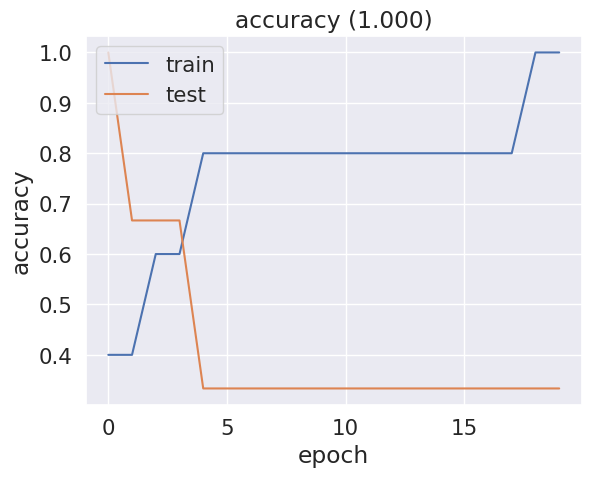

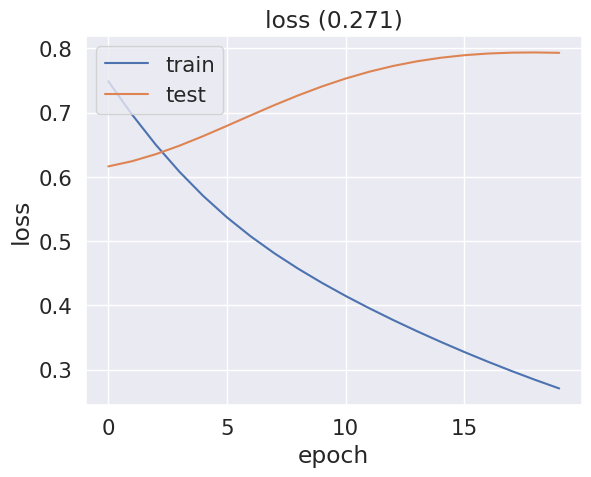

In [65]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('accuracy ('+str(format(history.history['accuracy'][-1],'.3f'))+')')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('loss ('+str(format(history.history['loss'][-1],'.3f'))+')')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_history(history)

L'objectif maintenant est de voir si le modèle appris permet de bien classer.   
Pour cela nous ajoutons des données qui n'ont pas été apprises. Il est indispensable pour pouvoir prédire la classe de transformer les données comme précédemment (tokens, padding, même longueur de vecteur, ...).

In [66]:

# Utilisation d'un nouveau jeu de tests
testmodel=["Mice are gray",
          "The beautiful red tomatoes",
          "The dog runs in the forest"]

testlabel= array([1,1,0])

# comme précédemment il est nécessaire de transformer en tokens
mytesttokens = Tokenizer()
mytesttokens.fit_on_texts(mesdocs)
print ("affichage premiers tokens",mytesttokens.word_index)

# la taille du vocabulaire doit donc toujours être supérieure à 1 (d'où le +1)
vocab_size_test = len(mytesttokens.word_index) + 1
print ("vocab_size",vocab_size_test)

# transformation en séquences et padding
# la méthode texts_to_sequences permet de transformer les documents avec l'index associé
encoded_docs_test = mytokens.texts_to_sequences(testmodel)
print ("docs",testmodel)
print("encoded_docs",encoded_docs_test)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=MAX_LENGTH, padding='post')
print("padded_docs",padded_docs_test)

affichage premiers tokens {'the': 1, 'is': 2, 'car': 3, 'sky': 4, 'really': 5, 'blue': 6, 'today': 7, 'bananas': 8, 'are': 9, 'normally': 10, 'yellow': 11, 'nice': 12, 'dog': 13, 'jumps': 14, 'in': 15, 'air': 16, 'forest': 17, 'all': 18, 'green': 19, 'cat': 20, 'purring': 21, 'drives': 22, 'quietly': 23, 'on': 24, 'road': 25, 'red': 26, 'of': 27, 'this': 28, 'beautiful': 29, 'embeddings': 30, 'can': 31, 'help': 32, 'classify': 33, 'better': 34}
vocab_size 35
docs ['Mice are gray', 'The beautiful red tomatoes', 'The dog runs in the forest']
encoded_docs [[9], [1, 29, 26], [1, 13, 15, 1, 17]]
padded_docs [[ 9  0  0  0  0  0  0  0  0  0]
 [ 1 29 26  0  0  0  0  0  0  0]
 [ 1 13 15  1 17  0  0  0  0  0]]


La prédiction se fait alors par :

1/1 [==============================] - 0s 58ms/step
Accuracy : 0.667
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         1
           1    0.66667   1.00000   0.80000         2

    accuracy                        0.66667         3
   macro avg    0.33333   0.50000   0.40000         3
weighted avg    0.44444   0.66667   0.53333         3



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


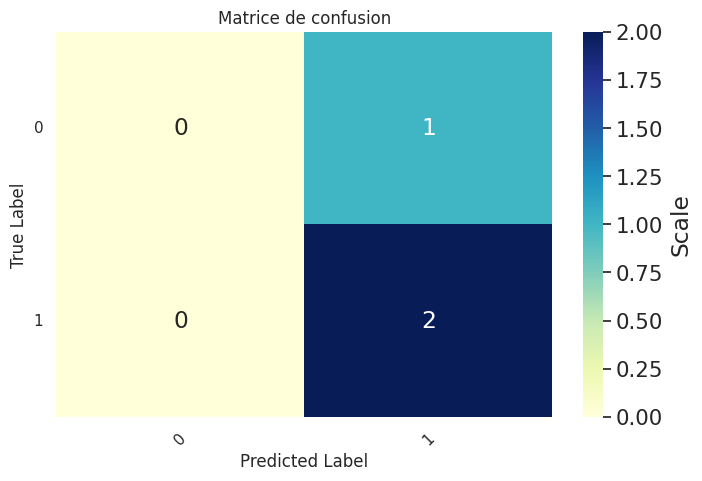

In [67]:

y_pred=(firstmodel.predict(padded_docs_test) > 0.5).astype("int32")

# Affichage des résultats
MyshowAllScores(testlabel,y_pred)


La cellule suivante regroupe en une seule fois toutes les cellules précédentes afin d'avoir une vision globale avec l'approche classique jeu de données et jeu d'apprentissage :

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           2900      
                                                                 
 flatten_2 (Flatten)         (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 4,901
Trainable params: 2,001
Non-trainable params: 2,900
_________________________________________________________________
Epoch 1/50
1/1 - 1s - loss: 0.6357 - accuracy: 0.5000 - val_loss: 0.6834 - val_accuracy: 0.5000 - 721ms/epoch - 721ms/step
Epoch 2/50
1/1 - 0s - loss: 0.5996 - accuracy: 0.8333 - val_loss: 0.6814 - val_accuracy: 0.5000 - 38ms/epoch - 38ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5656 - accuracy: 0.8333 - val_loss: 0.

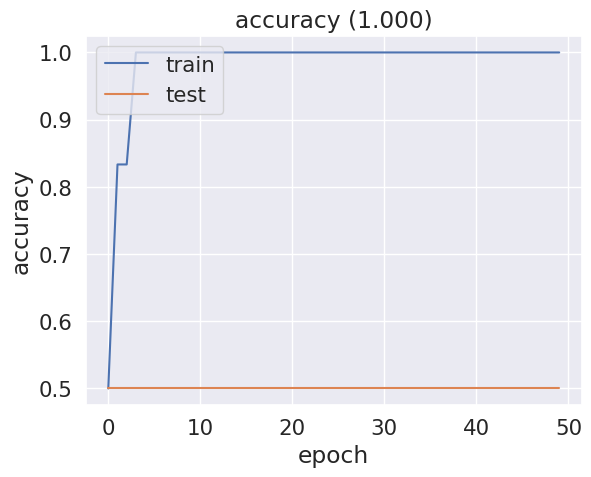

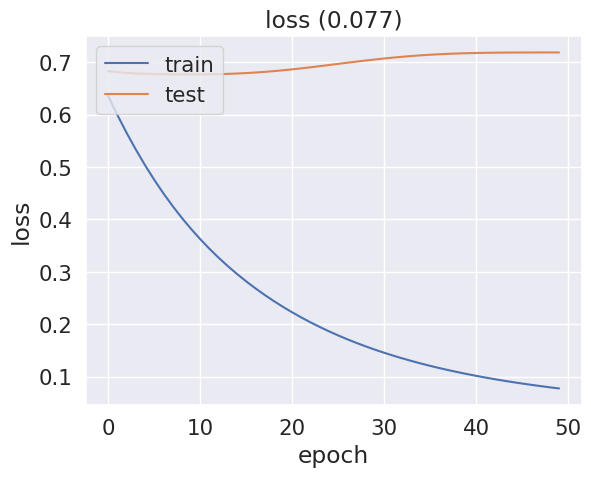

1/1 [==============================] - 0s 56ms/step
Accuracy : 0.333
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         1
           1    0.50000   0.50000   0.50000         2

    accuracy                        0.33333         3
   macro avg    0.25000   0.25000   0.25000         3
weighted avg    0.33333   0.33333   0.33333         3



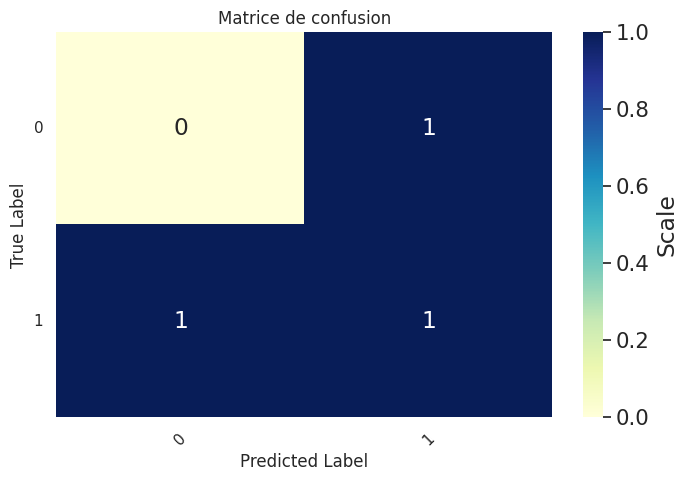

In [68]:
mesdocs = ["The sky is really blue today",
           "Bananas are normally yellow",
          "The nice dog jumps in the air",
          "The forest is all green",
           "The cat is purring",
           "The car drives quietly on the road",
            "The red of this car is beautiful",
           "Embeddings can help classify better",
           "Mice are gray",
           "The beautiful red tomatoes",
          "The dog runs in the forest"
           ]

# les labels des classes sont positionnés à 1 si le mot contient une couleur
labels = array([1,1,0,1,0,0,1,0,1,1,0])

# separation du jeu de données en test et apprentissage
X_train, X_test, y_train, y_test = train_test_split(mesdocs, labels, test_size=0.2, random_state=seed)

seed=7
MAX_LENGTH = 20
DIMENSION=100
# découpage en jeu de test et d'apprentissage
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# transformation du jeu d'apprentissage
tokens = Tokenizer()
tokens.fit_on_texts(X_train)
vocab_size = len(tokens.word_index) + 1
encoded_docs = tokens.texts_to_sequences(X_train)
X_train = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
# calcul de la matrice des embeddings
embedding_matrix=get_embedding_matrix(model_stanford,tokens,vocab_size,DIMENSION)

# Création du modèle
firstmodel =MyfirstModel(vocab_size, MAX_LENGTH, embedding_matrix, DIMENSION)

# découpage du jeu d'apprentissage en apprentissage et test pour évaluer le modèle en apprentissage
X_train_transformed, X_val_transformed, y_train, y_val = train_test_split(X_train, y_train,
                                                              test_size=0.2, random_state=seed)
# application du modèle
history=firstmodel.fit(X_train_transformed, y_train, epochs=50, verbose=2,
                       validation_data=(X_val_transformed,y_val))

plot_history(history)

# prediction
# transformation du jeu de test
testtokens = Tokenizer()
testtokens.fit_on_texts(X_test)
vocab_size_test = len(testtokens.word_index) + 1
encoded_docs_test = testtokens.texts_to_sequences(X_test)
X_test_transformed = pad_sequences(encoded_docs_test, maxlen=MAX_LENGTH, padding='post')

# calcul de la prédiction
y_pred=(firstmodel.predict(X_test_transformed) > 0.5).astype("int32")

# Affichage des résultats
MyshowAllScores(y_test,y_pred)


<font color=red>Exercice :</font> compléter la cellule suivante pour créer un nouveau classifier sur le jeu de données ReviewsLabelled.csv. Nous restons sur une classification binaire (à noter la fonction sigmoid qui devrait être remplacée par une fonction softmax à la fin du réseau pour une classification multiclasses).

In [69]:
def MyfirstModel(vocab_size, max_length, embedding_matrix, dimension):
  model = Sequential()
  model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compilation du réseau - adam pour accélérer
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # résumé du réseau
  model.summary()
  #plot_model(model, to_file='model.png', show_shapes=True)
  plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
  Image('model.png')
  return model



df_donnees = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')


print ("mélange du fichier ")
df_donnees=df_donnees.sample(frac=1).reset_index(drop=True)

print ("les 10 premières lignes du fichier :")
display(df_donnees[0:10])

# selection des données
X=df_donnees.sentence
y=df_donnees.sentiment




mélange du fichier 
les 10 premières lignes du fichier :


,sentence,sentiment,source
0,I'll be looking for a new earpiece.,0,amazon
1,"Great place to eat, reminds me of the little m...",1,yelp
2,My side Greek salad with the Greek dressing wa...,1,yelp
3,I ordered the Lemon raspberry ice cocktail whi...,1,yelp
4,"Thus far, have only visited twice and the food...",1,yelp
5,"The writer, Gorman Bechard, undoubtedly did hi...",1,imdb
6,It was a pale color instead of nice and char a...,0,yelp
7,"An Italian reviewer called this ""a small, grea...",1,imdb
8,"A mature, subtle script that suggests and occa...",1,imdb
9,That's how I'd describe this painfully dreary ...,0,imdb


<font color=blue>Solution :</font>

                                            sentence  sentiment  source
0       The service here leaves a lot to be desired.          0    yelp
1           The Jabra EarGels fit my ears very well.          1  amazon
2  The phone takes FOREVER to charge like 2 to 5 ...          0  amazon
3  Then I watched it again two Sundays ago (March...          1    imdb
4                The buttons for on and off are bad.          0  amazon
5                                 is pretty funny.            1    imdb
6         Spend your money and time some place else.          0    yelp
7                             Avoid, avoid, avoid!            0    imdb
8              Buy it, play it, enjoy it, love it.            1    imdb
9  I really loved the story line and the poler be...          1    imdb
affichage premiers tokens {'the': 1, 'and': 2, 'i': 3, 'a': 4, 'is': 5, 'it': 6, 'to': 7, 'of': 8, 'this': 9, 'was': 10, 'in': 11, 'for': 12, 'not': 13, 'that': 14, 'with': 15, 'my': 16, 'very': 17, 'good': 1

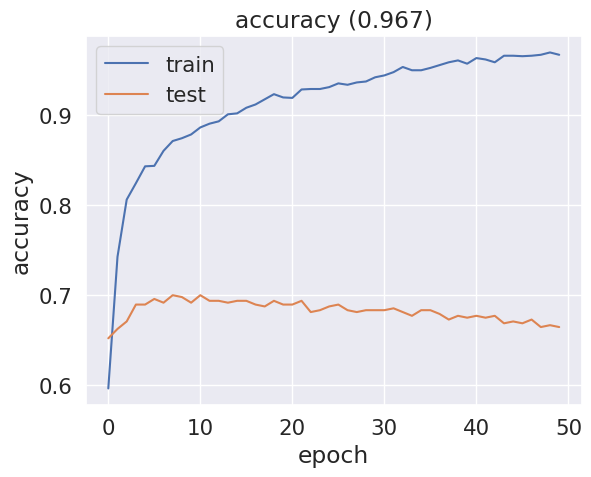

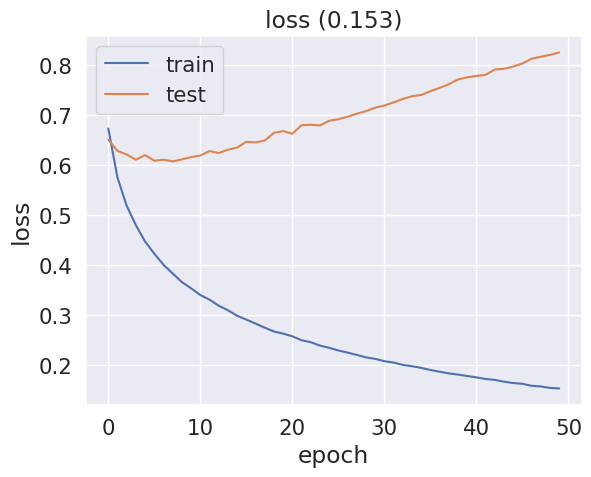

19/19 [==============================] - 0s 3ms/step
Accuracy : 0.493
Classification Report
              precision    recall  f1-score   support

           0    0.50671   0.49026   0.49835       308
           1    0.48013   0.49658   0.48822       292

    accuracy                        0.49333       600
   macro avg    0.49342   0.49342   0.49328       600
weighted avg    0.49378   0.49333   0.49342       600



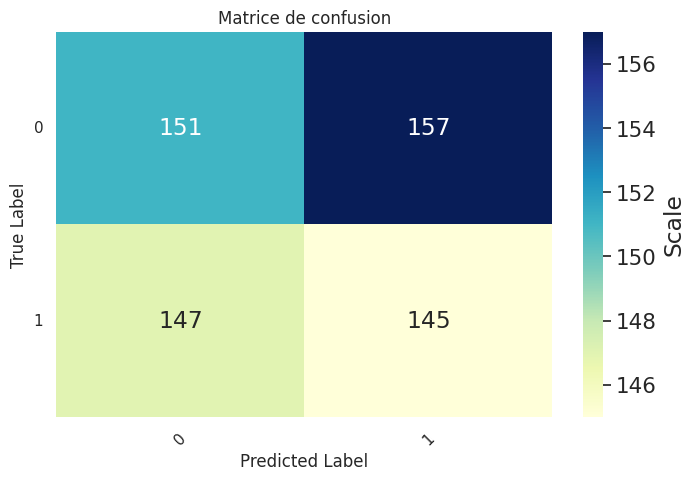

In [70]:
def MyfirstModel(vocab_size, max_length, embedding_matrix, dimension):
  model = Sequential()
  model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compilation du réseau - adam pour accélérer
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # résumé du réseau
  model.summary()
  #plot_model(model, to_file='model.png', show_shapes=True)
  plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
  Image('model.png')
  return model



df_donnees = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='	', encoding='utf8')


df_donnees=df_donnees.sample(frac=1).reset_index(drop=True)
print(df_donnees[0:10])

# selection des données
X=df_donnees.sentence
y=df_donnees.sentiment

seed=7
MAX_LENGTH = 20
DIMENSION=100

# découpage en jeu de test et d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


# traitement des données d'apprentissage
tokens = Tokenizer()
tokens.fit_on_texts(X_train)
print ("affichage premiers tokens",tokens.word_index)
vocab_size = len(tokens.word_index) + 1
print ("vocab_size",vocab_size)

# pour pouvoir traiter les documents, il est nécessaire de les encoder en entier
# la méthode texts_to_sequences permet de transformer les documents avec l'index associé
encoded_docs = tokens.texts_to_sequences(X_train)

MAX_LENGTH = 100
X_train_transformed = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')


embedding_matrix=get_embedding_matrix(model_stanford,tokens,vocab_size,DIMENSION)
# découpage du jeu d'apprentissage en apprentissage et test pour évaluer le modèle en apprentissage
X_train_transformed, X_val_transformed, y_train, y_val = train_test_split(X_train_transformed, y_train,
                                                              test_size=0.2, random_state=seed)

# creation du modèle
firstmodel = MyfirstModel(vocab_size, MAX_LENGTH, embedding_matrix, DIMENSION)


history=firstmodel.fit(X_train_transformed, y_train, epochs=50, verbose=2,
                       validation_data=(X_val_transformed,y_val))

plot_history(history)
# calcul de la prédiction
testtokens = Tokenizer()
testtokens.fit_on_texts(X_test)
vocab_size_test = len(testtokens.word_index) + 1
encoded_docs_test = testtokens.texts_to_sequences(X_test)
X_test_transformed = pad_sequences(encoded_docs_test, maxlen=MAX_LENGTH, padding='post')

y_pred=(firstmodel.predict(X_test_transformed) > 0.5).astype("int32")

# Affichage des résultats
MyshowAllScores(y_test,y_pred)

<font color=red>Exercice :</font> tester le code précédent mais en utilisant les deux modèles définis ci-dessous. Le premier utilise des CNN et le second du LSTM, i.e. il tient compte de l'ordre des mots. Que constatez vous par rapport aux autres classifiers.

In [71]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def MyCNNModel(vocab_size, max_length, embedding_matrix, dimension):
  model = Sequential()
  model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

def MyLSTMModel(vocab_size, max_length, embedding_matrix, dimension):
  model = Sequential()
  model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(dimension)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

<font color=blue>Solution :</font>

Utilisation de CNN
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          466900    
                                                                 
 conv1d (Conv1D)             (None, 93, 32)            25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 32)           0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 1472)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                14730     
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                   

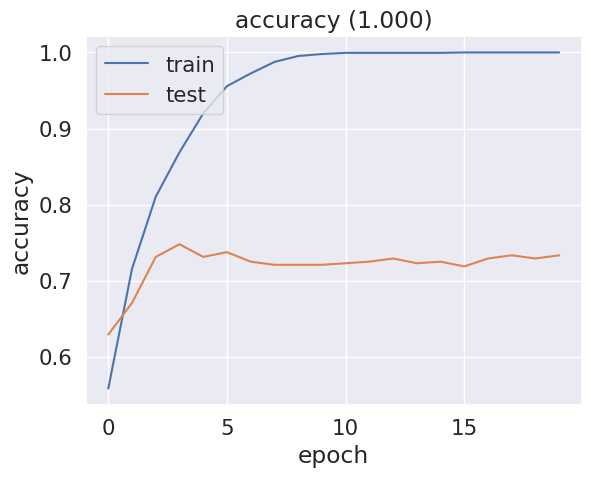

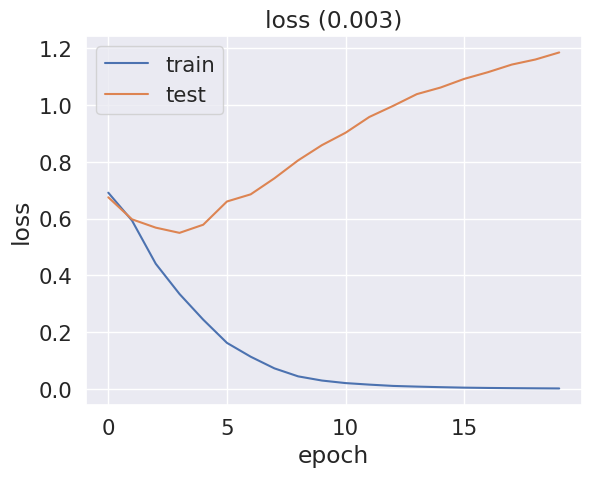

19/19 [==============================] - 0s 11ms/step
Accuracy : 0.515
Classification Report
              precision    recall  f1-score   support

           0    0.52921   0.50000   0.51419       308
           1    0.50162   0.53082   0.51581       292

    accuracy                        0.51500       600
   macro avg    0.51541   0.51541   0.51500       600
weighted avg    0.51578   0.51500   0.51498       600



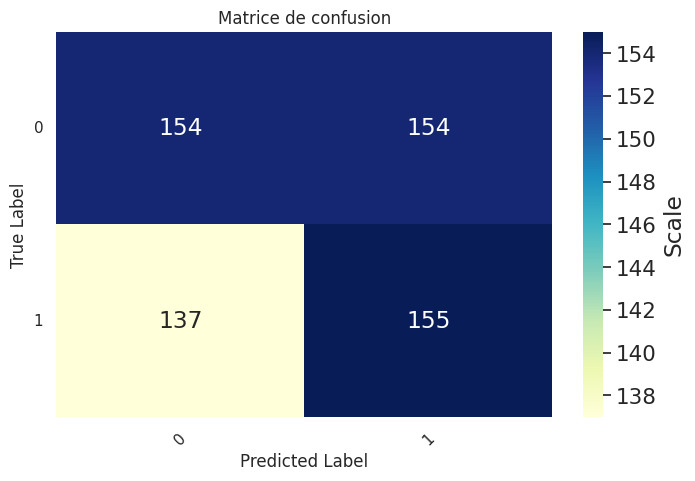

Utilisation de LSTM
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          466900    
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 627,901
Trainable params: 161,001
Non-trainable params: 466,900
_________________________________________________________________
Epoch 1/20


In [ ]:
# creation du modèle
print ("Utilisation de CNN")
firstmodel = MyCNNModel(vocab_size, MAX_LENGTH, embedding_matrix, DIMENSION)


history=firstmodel.fit(X_train_transformed, y_train, epochs=20, verbose=2,
                       validation_data=(X_val_transformed,y_val))

plot_history(history)
# calcul de la prédiction
y_pred=(firstmodel.predict(X_test_transformed) > 0.5).astype("int32")

# Affichage des résultats
MyshowAllScores(y_test,y_pred)

print ("Utilisation de LSTM")
secondmodel = MyLSTMModel(vocab_size, MAX_LENGTH, embedding_matrix, DIMENSION)


history=secondmodel.fit(X_train_transformed, y_train, epochs=20, verbose=2,
                       validation_data=(X_val_transformed,y_val))

plot_history(history)
# calcul de la prédiction
y_pred=(secondmodel.predict(X_test_transformed) > 0.5).astype("int32")

# Affichage des résultats
MyshowAllScores(y_test,y_pred)

Le fait d'utiliser des word embeddings pour la classification de textes est un réel avantage. Il est courant, voir indispensable maintenant, lorsque l'on travaille sur des données (e.g. compte rendu médical, relevés d'opérations, comptes rendus, documents dans une langue étrangère, etc.) pas trop classiques comme les dépêches de presse ou des opinions, pour lesquelles il existe déjà des embeddings, de pouvoir apprendre le plus de contexte possible et donc avant de faire une classification d'apprendre sur l'ensemble du corpus.
